Regression tasks are those where you need an algorithm that ultimately outputs a number. There are a number of ways to produce continuous numeric outputs, but the simplest and most commonly used method is linear regression models. In this checkpoint, we explore how to formulate a linear regression model and estimate it using Ordinary Least Squares (OLS) method.

Although it is not the only one, OLS is by far the most common method of estimating linear regression models. This technique is so common and canonical that people will often refer to it simply as "regression", even though there are plenty of other techniques and types of models that qualify as regressions. We'll cover the basic formulation of the linear regression model and the OLS algorithm.

We'll cover the following topics in this checkpoint:

* formula for linear regression models
* data exploration
* ordinary least squares (OLS)
* optimizing coefficients

This checkpoint ends with an assignment in which you'll build a model to predict house prices.


## Formulating a linear regression model

In the previous checkpoint, we saw that linear regression model plots a line of best fit representing the relationship between the features and the target. To be more precise, a linear regression model can be formulated mathematically like this:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon \qquad(eq.1)$$

In (eq.1), $y$ represents the target variable and $x_1, x_2,..., x_n$s represent the features. $n$ denotes the number of the features. The unknowns of the equation above are the $\beta$ terms. $ \beta_0 $ refers to the intercept, bias term or constant. All the others ($\beta_1, \beta_2,...,\beta_n$) are called the coefficients. The $\epsilon$ is the error term which represents the information in $y$ that is unexplained by the features.

**Note:** In linear regression models, it's common to refer to features in a model as __explanatory variables__ or __independent variables__ and the target variable as the __explained__ or __dependent variable__. So, don't be surprised if you stumble upon these alternative terms in other places. 

The expression above can be written in a more compact form using the summation ( $\sum$ ) operator as follows:

$$ y = \beta_0 + \sum_{i=1}^{n}\beta_ix_i + \epsilon \qquad(eq.2)$$


In (eq.2), $\sum_{i=1}^{n}$ adds up each $\beta_ix_i$ where the subscript $i$ refers to the index of the features and the coefficients. Hence $\sum_{i=1}^{n}$ starts from $i=1$ and goes till $i=n$.


## Insurance charges dataset

Throughout this module, we'll demonstrate linear regression modeling on a medical cost dataset originally from Kaggle. The original dataset is called "Medical Cost Personal Dataset" and can be found at this [link](https://www.kaggle.com/mirichoi0218/insurance/home). We'll be working with a SQL-based version of this dataset hosted on a Postgres server, but if you want full documentation on the data, refer to the Kaggle link.

The data is about the costs charged by the insurance companies to individuals. These are costs that the insured individuals were required to pay after the insurance company made payments to medical providers. The dataset includes six variables as described below:

* age: The age of the individual. It's a numeric.
* sex: The biological sex of the insured. It is categorical (male or female).
* bmi: Body mass index. This index indicates whether an individual's weight is relatively high or low, based on height. This index defines an ideal range between 18.5 and 24.9. The variable is continuous.
* children: How many dependent children the insured person has. Dependents are covered by the insurance plan. This is a numeric variable.
* smoker: This categorical variable (yes | no) indicates or not the person smokes.
* region: the person's residential area in the US. It's a categorical variable (northeast, southeast, southwest, northwest). 
* charges: The medical costs (in US dollars) billed by the insurance company. It's a continuous variable.

In the examples, our target variable will be the "charges" billed by the insurance company. Since, it's a continuous variable, we're dealing with a regression task.


## Preliminary data exploration

To choose the features we use in our first model, we do a brief exploratory analysis here. First, let's import the relevant libraries:

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'


Next, we load the data from the Postgresql database and print out some observations:

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


First, let's look at the distribution of our target variable: charges. Investigatin how our target is distributed helps us understand the relationship between the target and the features. It's also useful to discover some problems with our model as we'll discuss in the next checkpoint:

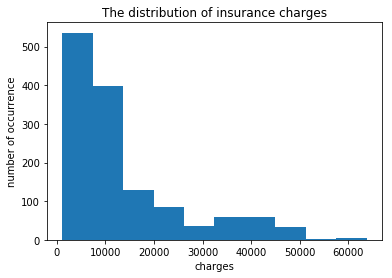

In [3]:
plt.hist(insurance_df.charges)
plt.title("The distribution of insurance charges")
plt.xlabel("charges")
plt.ylabel("number of occurrence")
plt.show()

We observe that charges is not distributed normally. Instead it's highly skewed. **Skewness** is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the charges variable is not symmetric but skewed to the left. The majority of the observations have low charges values and few of the observations have high charges values. This makes the distribution of the charges clustered at the left-most part of the histogram.

Notice that the categorical variables are strings and we need to convert them to numerical values. This can be viewed as part of a feature enginnering process. One of the most convenient ways of converting categorical variables into numerical ones is called **one hot encoding**. In one hot encoding, we create a sperate binary variable which takes 0 or 1 for all of the unique values of the categorical variable. Pandas' `get_dummies()` function does this job for us. 

Below, we call the `get_dummies()` function for the *sex* and *smoker* categorical variables in our dataset. Since both *sex* and *smoker* variables include two values, the `get_dummies()` function will create two dummy (indicator) variables for us. Since one of them is enough for us to indicate whether the person is male or not and is a smoker or not, we keep only one of the newly created dummies bot for *sex* and *smoker* in our data frame. We do this by feeding the parameter `drop_first` which is set to `True` into the `get_dummies()` function.

In [4]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

insurance_df.region[np.where(np.isin(insurance_df.region, "southwest"))[0]] = 0
insurance_df.region[np.where(np.isin(insurance_df.region, "northwest"))[0]] = 1
insurance_df.region[np.where(np.isin(insurance_df.region, "southeast"))[0]] = 2
insurance_df.region[np.where(np.isin(insurance_df.region, "northeast"))[0]] = 3

At a first glance, gender and smoking may play an important role in the insurance charges. So, let's look at whether we see some differences between the average costs billed to different genders and to the ones who smoke:

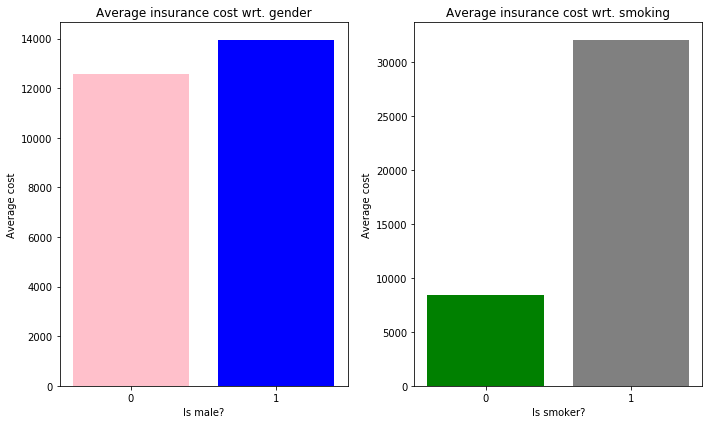

In [5]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(insurance_df.groupby("is_male")["charges"].mean().index, insurance_df.groupby("is_male")["charges"].mean(),
       color=("pink","blue"))
plt.title("Average insurance cost wrt. gender")
plt.ylabel("Average cost")
plt.xlabel("Is male?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(insurance_df.groupby("is_smoker")["charges"].mean().index, insurance_df.groupby("is_smoker")["charges"].mean(),
       color=("green","grey"))
plt.title("Average insurance cost wrt. smoking")
plt.ylabel("Average cost")
plt.xlabel("Is smoker?")
plt.xticks([0,1])

plt.tight_layout()
plt.show()


As can be seen in the graph, the average costs seem to be different between different groups. So on average, males seem to be charged higher than females and smokers are charged higher than non-smokers. Let's build our first model using these two features.

## Modeling the insurance charges with linear regression

Let's illustrate how we can model the insurance cost using a simple linear regression model. Our target variable is "charges" and we include two categorical variables as our features: "is_male" and "is_smoker". Hence, our model becomes: 

$$ charges = \beta_0 + \beta_1is\_smoker + \beta_2is\_male + \epsilon \qquad(eq.3)$$

$\beta_0$ is the constant and $\beta_1$ and $\beta_2$ are the coefficients of is_smoker and is_male dummies respectively. 

**An important remark**: Putting a constant in a model is optional, but it's a good idea to include a constant in every model you build. Even though you believe that the constant would be zero, letting the model to decide whether it is zero or not is the safest way.

## How to find the optimal values for the coefficients?

Formulating a model is the first step in a regression problem. But, we need to find a way to discover the optimal values for the unknowns (the coefficients) in the equation above. Recall that the process of finding the optimal values of the unknowns is called **optimization**.  Here,  we need an optimization algorithm to solve for the optimal coefficient values. 

The most common optimization algorithm used in the simple linear regression models is called **Ordinary Least Squares** or **OLS**.


## The machinery of OLS

OLS tries to minimize the squared sums of the error terms ($\epsilon$) in the model. We can write the error term as following:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i ) = \epsilon \qquad(eq.4)$$

If we take the squares of the each sides, it becomes:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i )^2 = \epsilon^2 \qquad(eq.5)$$

Notice that, this error term is just for a single observation. If we have, say, $m$ observations in our dataset, then the sum of the squared errors can be represented like this:

$$\sum_{j=1}^{m}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_ix_{ij} )^2 = \sum_{j=1}^{m}\epsilon_j^2 \qquad(eq.6)$$

Recall that the index $i$ was representing the number of the features in the model. In the equation above, the index $j$ represents the number of observations. Hence, we go over each observation and add up their squared error terms. However, using matrix notation simplifies the expression:

$$y - \beta X = \epsilon \qquad(eq.7)$$

We will not go deeper into the derivation of the coefficients, but all you need to do is to take the derivative of the both sides with respect to each coefficient and equate them to zero! If you solve the resulting equations, then you end up with the optimal values of the coefficients:

$$ \hat{\beta} = (X^TX)^{-1}X^Ty \qquad(eq.8)$$

In (eq.8), $\hat{\beta}$ indicates the estimated coefficients vector, $X^T$ refers to the transpose of the feature matrix (X) and superscript $^{-1}$ refers to the inverse of a matrix.

That's it! If you want to learn more about the derivation steps, you can read the [Wikipedia article](https://en.wikipedia.org/wiki/Ordinary_least_squares).

## An initial model for insurance charges

Using (eq.3) above, now we build a simple linear regression model and estimate it using OLS. So far in the bootcamp, we mainly used scikit-learn as our machine learning package. Here, we want to introduce another popular library for regression analysis called statsmodels. You may find using statsmodels for fitting linear regression models easier because it's `summary()` function outputs many important metrics in a tabular form. Getting the same metrics in scikit-learn requires more work.

Let's begin with scikit-learn. We'll use `LinearRegression()` model from the `linear_model` module:

In [6]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.035592512439


`LinearRegression()`'s `fit()` method runs OLS algorithm by default. Since we get the parameters using OLS, we can rewrite our model:

$$ charges = 8466.04 + -65.38is\_male + 23622.13is\_smoker \qquad(eq.9)$$

Our estimated constant is 8466.04. Estimated coefficients of is_male and is_smoker features are -65.38 and 23622.13 respectively. Later in this module, we'll delve into how to interpret these estimated coefficients.

Now, we run the same model this time by using statsmodels. If you didn't install it already, you can run `pip install statsmodels` from the command line. 

In [7]:
import statsmodels.api as sm

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1088.
Date:                Fri, 02 Nov 2018   Prob (F-statistic):          4.78e-281
Time:                        10:24:52   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1335   BIC:                         2.768e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8466.0356    303.541     27.891      0.000    7870.566    9061.506
is_male      -65.3787    409.809     -0.160      0.873    -869.318     738.561
is_smoker   2.362e+04    507.736     46.524      0.000    2.26e+04    2.46e+04
==============================================================================
Omnibus:                      135.842   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.897
Skew:                           0.727   Prob(JB):                     9.71e-47
Kurtosis:                       4.299   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First notice that we added constant to our existing feature set using this code:`X = sm.add_constant(X)`. This is because, statsmodels' `fit()` function doesn't add constant by default as opposed to scikit-learn's `fit()` function.

Second, when we call the `summary()` function on the fitted ols model, it prints out a table full of some statistics. For example, in the upper side of the table we see statistics like R-squared, adjusted R-squared, F-statistic, Log-likelihood, AIC and BIC. Those are related with the goodness of fit of our model. In the lower part, we see statistics like Durbin-Watson, Jarque-Bera, skewness and kurtosis. Those statistics are related with whether our model satisfies some assumptions of the linear regression model. For example, skewness is a measure of how asymmetric our data is and kurtosis is a measure of whether our data is heavy or light tailed with respect to a normal distribution. Don't worry about the details of these statistics as we'll go over some of them later in this module. For now, notice that in the middle of the table, estimated values for the coefficients are given and those are exactly the same as what we got from the scikit-learn.

## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful postgresql database. You can look at the example above for inspiration on how to generate the database engine url. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections.
* Investigate the data and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in the prediction of the house prices.
* Build your initial model using these features and estimate the parameters using OLS.